# Little's Law simulation

This notebook provides a simple, single queue simulation. We generate jobs, run them through the system and compare the behavior to Little's Law for verification.

The goal is to develop intuitions about the underlying dynamics of the system, especially around inputs, outputs, and how queueing processes convert inputs into outputs. On the input side we want to understand how to reduce response times to queueing network parameters. On the output side we want to understand the performance metrics available and how we can measure them.

**Reduction of response times to queueing network parameters.** First we show how to reduce response times to the following queueing network parameters:

- mean arrival rate
- mean service rate

Eventually we will also incorporate

- job scheduling policy: policy around how we prioritize waiting jobs; and
- job assignment policy: policy around how we assign jobs to resources

though this notebook simply assumes First-Come-First-Served (FCFS) scheduling, and assumes a single resource (which makes assignment not applicable).

**Performance measurement.** We show how to measure the following performance metrics:

- response time
- number of jobs in the system
- wait time
- device utilization
- throughput

## Little's Law for open systems
$$ E[N] = \lambda E[T] $$

where

- $\lambda$ = mean job arrival rate
- $N$ = number of jobs in the system
- $T$ = response time (departure time minus arrival time)
- $E$ is the expectation operator

## 0 Setup 

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng(42)

In [3]:
# Simulation parameters
num_events = 4000
mean_arrival_rate = 16.0  # lambda
mean_service_rate = 18.0  # mu

## 1 Generate arrival times 

In [4]:
mean_interarrival_time = 1.0 / mean_arrival_rate
num_bins_arrival = int(num_events / mean_arrival_rate)
num_bins_arrival

250

In [5]:
interarrival_times = rng.exponential(scale=mean_interarrival_time, size=num_events)

In [6]:
interarrival_times[0:15]

array([0.15026304, 0.14601185, 0.14904756, 0.01748714, 0.00540234,
       0.09079128, 0.08812254, 0.1952685 , 0.00495589, 0.06541005,
       0.00440227, 0.06806398, 0.10820796, 0.02418093, 0.0769741 ])

In [7]:
print(f"mean_interarrival_time_actual   ={mean_interarrival_time}")
print(f"mean_interarrival_time_observed ={np.mean(interarrival_times)}")

mean_interarrival_time_actual   =0.0625
mean_interarrival_time_observed =0.06250397901153028


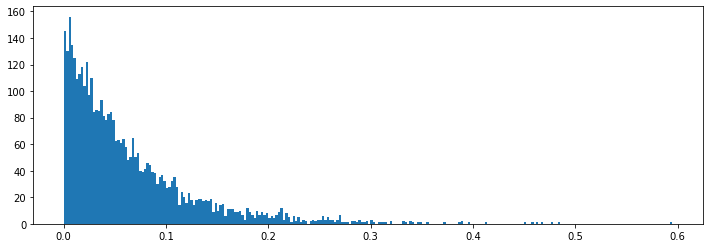

In [8]:
plt.figure(figsize=(12, 4))
plt.hist(interarrival_times, bins=num_bins_arrival)
plt.show()

In [9]:
arrival_times = np.cumsum(interarrival_times)

In [10]:
arrival_times.shape

(4000,)

In [11]:
arrival_times[0:100]

array([0.15026304, 0.29627489, 0.44532245, 0.4628096 , 0.46821193,
       0.55900322, 0.64712576, 0.84239426, 0.84735014, 0.9127602 ,
       0.91716247, 0.98522644, 1.0934344 , 1.11761533, 1.19458943,
       1.20420026, 1.20992384, 1.22962254, 1.2859475 , 1.31175908,
       1.3897207 , 1.40369422, 1.51856737, 1.59526023, 1.63624749,
       1.66231541, 1.69064789, 1.69546521, 1.70669223, 1.74952476,
       1.77381727, 1.8528302 , 1.89711086, 1.91198149, 1.94079951,
       1.9808968 , 2.00238639, 2.02250584, 2.07743801, 2.09599721,
       2.17935361, 2.26628261, 2.33403779, 2.33860206, 2.40948128,
       2.49412741, 2.56425489, 2.58175796, 2.60181647, 2.61217496,
       2.63432268, 2.63564392, 2.64610369, 2.72829474, 2.97802951,
       3.01325064, 3.03100312, 3.05586289, 3.07844678, 3.08654888,
       3.1542567 , 3.24024725, 3.33448532, 3.666353  , 3.79801926,
       3.90082338, 3.96604159, 4.00307436, 4.0058527 , 4.06564038,
       4.10447682, 4.19872441, 4.32547451, 4.34622881, 4.34933

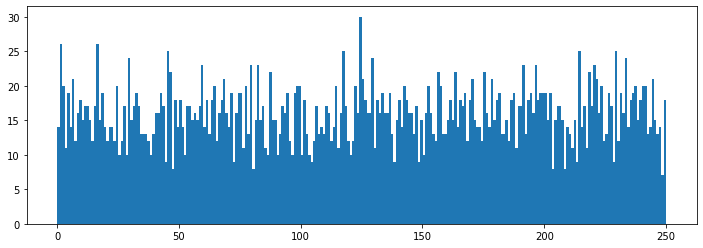

In [12]:
plt.figure(figsize=(12, 4))
counts, bins, bars = plt.hist(arrival_times, bins=num_bins_arrival)
plt.show()

In [13]:
np.mean(counts)

16.0

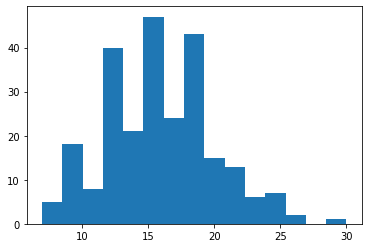

In [14]:
plt.hist(counts, bins=15)
plt.show()

## 2 Generate service times 

In [15]:
mean_service_time = 1.0 / mean_service_rate  # E[S] = 1 / mu
num_bins_service = int(num_events / mean_service_rate)

In [16]:
service_times = rng.exponential(scale=mean_service_time, size=num_events)

In [17]:
service_times[0:15]

array([0.00668553, 0.01270898, 0.00328629, 0.08525936, 0.06999469,
       0.02415699, 0.06019742, 0.12377094, 0.01045287, 0.02642004,
       0.00613009, 0.00087379, 0.00957915, 0.05568526, 0.04407284])

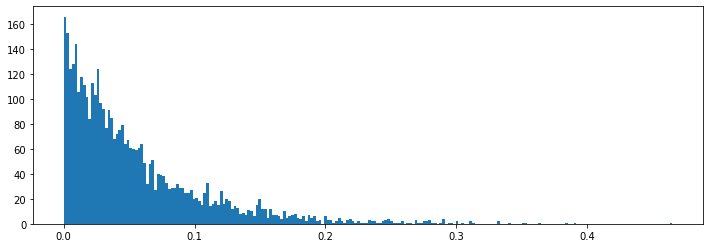

In [18]:
plt.figure(figsize=(12, 4))
plt.hist(service_times, bins=num_bins_service)
plt.show()

## 3 Calculate job start and end (departure) times

In [19]:
jobs_df = pd.DataFrame({
    "arrive_time": arrival_times,
    "service_time": service_times,
    "start_time": np.zeros(num_events),
    "depart_time": np.zeros(num_events)
})

In [20]:
jobs_df.loc[0, "start_time"] = jobs_df.loc[0, "arrive_time"]
jobs_df.loc[0, "depart_time"] = jobs_df.loc[0, "start_time"] + jobs_df.loc[0, "service_time"]

In [21]:
for i in range(1, num_events):
    jobs_df.loc[i, "start_time"] = max(jobs_df.loc[i, "arrive_time"], jobs_df.loc[i-1, "depart_time"])
    jobs_df.loc[i, "depart_time"] = jobs_df.loc[i, "start_time"] + jobs_df.loc[i, "service_time"]

## 4 Estimate expected response time $E[T]$

In [22]:
jobs_df["response_time"] = jobs_df["depart_time"] - jobs_df["arrive_time"]

In [23]:
jobs_df.head(20)

,arrive_time,service_time,start_time,depart_time,response_time
0,0.150263,0.006686,0.150263,0.156949,0.006686
1,0.296275,0.012709,0.296275,0.308984,0.012709
2,0.445322,0.003286,0.445322,0.448609,0.003286
3,0.462810,0.085259,0.462810,0.548069,0.085259
4,0.468212,0.069995,0.548069,0.618064,0.149852
5,0.559003,0.024157,0.618064,0.642221,0.083217
6,0.647126,0.060197,0.647126,0.707323,0.060197
7,0.842394,0.123771,0.842394,0.966165,0.123771
8,0.847350,0.010453,0.966165,0.976618,0.129268
9,0.912760,0.026420,0.976618,1.003038,0.090278


In [24]:
mean_response_time = jobs_df["response_time"].mean()

In [25]:
mean_response_time

0.34052028527578576

## 5 Estimate expected job count $E[N]$

In [26]:
# Build intervals and their corresponding job counts so we can calculate E[N].
# To do this, we will have two pointers: one for the arrival times and the other for the end (departure) times.
# At each iteration, the lower-valued pointer is the next interval's upper bound. We increment the job count
# whenever we choose the arrival time and we decrement the job count whenever we choose the end time.
def build_intervals(arrivals, departures):
    intervals_df = pd.DataFrame(columns=["lo_bd", "up_bd", "width", "num_jobs"])

    lo_bd = 0.0
    arrival_idx = 0
    end_idx = 0
    num_jobs = 0
    while arrival_idx < num_events and end_idx < num_events:
        num_jobs_orig = num_jobs
        curr_arrival = arrivals[arrival_idx]
        curr_end = departures[end_idx]
        if curr_arrival < curr_end:
            num_jobs = num_jobs + 1
            up_bd = curr_arrival
            arrival_idx = arrival_idx + 1
        else:
            num_jobs = num_jobs - 1
            up_bd = curr_end
            end_idx = end_idx + 1

        width = up_bd - lo_bd
        intervals_df = intervals_df.append({
            "lo_bd": lo_bd,
            "up_bd": up_bd,
            "width": width,
            "num_jobs": num_jobs,
            "num_jobs_change": num_jobs - num_jobs_orig,
            "weighted_num_jobs": width * num_jobs
        }, ignore_index=True)

        lo_bd = up_bd
    
    return intervals_df

In [27]:
intervals_df = build_intervals(jobs_df["arrive_time"], jobs_df["depart_time"])
intervals_df.head(20)

,lo_bd,up_bd,width,num_jobs,num_jobs_change,weighted_num_jobs
0,0.000000,0.150263,0.150263,1.0,1.0,0.150263
1,0.150263,0.156949,0.006686,0.0,-1.0,0.000000
2,0.156949,0.296275,0.139326,1.0,1.0,0.139326
3,0.296275,0.308984,0.012709,0.0,-1.0,0.000000
4,0.308984,0.445322,0.136339,1.0,1.0,0.136339
5,0.445322,0.448609,0.003286,0.0,-1.0,0.000000
6,0.448609,0.462810,0.014201,1.0,1.0,0.014201
7,0.462810,0.468212,0.005402,2.0,1.0,0.010805
8,0.468212,0.548069,0.079857,1.0,-1.0,0.079857
9,0.548069,0.559003,0.010934,2.0,1.0,0.021869


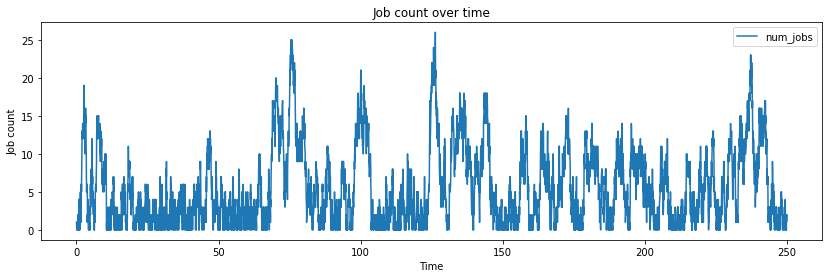

In [28]:
intervals_df.plot(
    x="lo_bd",
    y="num_jobs",
    title="Job count over time",
    xlabel="Time",
    ylabel="Job count",
    figsize=(14, 4))
plt.show()

## 6 Apply Little's Law

In [29]:
total_weighted_num_jobs = intervals_df["weighted_num_jobs"].sum()
total_width = intervals_df.iloc[-1]["up_bd"]
mean_num_jobs = total_weighted_num_jobs / total_width

In [30]:
print(f"total_weighted_num_jobs ={total_weighted_num_jobs}")
print(f"total_width             ={total_width}")
print(f"mean_num_jobs           ={mean_num_jobs}")

total_weighted_num_jobs =1380.4451295668437
total_width             =250.01591604612148
mean_num_jobs           =5.521429000992829


In [31]:
# Little's Law verification
mean_arrival_rate * mean_response_time

5.448324564412572

## 7 Estimate utilization 

In [32]:
busy = intervals_df.loc[intervals_df["num_jobs"] > 0.0, "width"].sum()
util = busy / total_width

In [33]:
util

0.9328865166743321

## 8 Estimate throughput 

In [34]:
print(f"num_events        ={num_events}")
print(f"total_width       ={total_width}")
print(f"mean_arrival_rate ={mean_arrival_rate}")
print(f"mean_service_rate ={mean_service_rate}")

num_events        =4000
total_width       =250.01591604612148
mean_arrival_rate =16.0
mean_service_rate =18.0


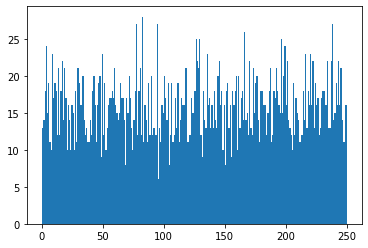

In [35]:
completions = intervals_df.loc[intervals_df["num_jobs_change"] == -1.0, "up_bd"]
completion_counts, _, _ = plt.hist(completions, bins=int(total_width))
plt.show()

In [36]:
# Jobs completed per bin
mean_throughput = np.mean(completion_counts)
mean_throughput

15.992

## 9 Estimate wait time 

In [37]:
jobs_df["wait_time"] = jobs_df["start_time"] - jobs_df["arrive_time"]

In [38]:
jobs_df.head(20)

,arrive_time,service_time,start_time,depart_time,response_time,wait_time
0,0.150263,0.006686,0.150263,0.156949,0.006686,0.000000
1,0.296275,0.012709,0.296275,0.308984,0.012709,0.000000
2,0.445322,0.003286,0.445322,0.448609,0.003286,0.000000
3,0.462810,0.085259,0.462810,0.548069,0.085259,0.000000
4,0.468212,0.069995,0.548069,0.618064,0.149852,0.079857
5,0.559003,0.024157,0.618064,0.642221,0.083217,0.059060
6,0.647126,0.060197,0.647126,0.707323,0.060197,0.000000
7,0.842394,0.123771,0.842394,0.966165,0.123771,0.000000
8,0.847350,0.010453,0.966165,0.976618,0.129268,0.118815
9,0.912760,0.026420,0.976618,1.003038,0.090278,0.063858


In [39]:
mean_wait_time = np.mean(jobs_df["wait_time"])
mean_wait_time

0.28666555397305143

In [40]:
# Note: E[response_time] = E[wait_time] + E[service_time]
print(f"mean_response_time                 ={mean_response_time}")
print(f"mean_wait_time + mean_service_time ={mean_wait_time + mean_service_time}")

mean_response_time                 =0.34052028527578576
mean_wait_time + mean_service_time =0.34222110952860696
